In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import sys, gc, warnings, random, math, time, datetime 
from tqdm import tqdm
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr

import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from utils import *

import os
print(os.listdir("../input/features/"))

['train_y.pkl', 'train_uid_features.pkl', 'train_features.pkl', 'useful_features.npy', 'test_features.pkl', 'test_uid_features.pkl', 'test.pkl', 'train.pkl']


In [2]:
train = pd.read_pickle('../input/features/train.pkl')
test = pd.read_pickle('../input/features/test.pkl')
train_y = train['isFraud'].copy()

print(train.shape)
print(train_y.shape)
print(test.shape)

(590540, 433)
(590540,)
(506691, 433)


In [3]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [4]:
for col in tqdm_notebook(train.columns):
    for df in [train, test]:
        df[col] = df[col].apply(lambda v: v if str(v)!='nan' else random.random())

In [5]:
def create_group(df, group, index):
    df["uid_" + str(index)] = 0
    for col in group:
        df["uid_" + str(index)] = df["uid_" + str(index)].astype(str)+'_'+df[col].astype(str)
    return df

In [6]:
def fe_w(train_df, test_df):
    
    print("fe with W...")
    
    uid1_group = ['ProductCD' ,'addr1', 'addr2', 'P_emaildomain', 'C1', 'C2', 'M4', 'M5', 'M6']
    uid2_group = ['ProductCD' ,'addr1', 'addr2', 'D10', 'P_emaildomain', 'D1', 'D2']
    uid3_group = ['ProductCD' ,'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card4', 'card5', 'card6', 'TransactionAmt']
    uid4_group = ['ProductCD' ,'addr1', 'addr2', 'D15',  "D1", "D2", "D15"]
    uid5_group = ['ProductCD' ,'addr1', 'addr2', "C13", "C14"]
    for df in [train_df, test_df]:
        df = create_group(df, uid1_group, "w_1")
        df = create_group(df, uid2_group, "w_2")
        df = create_group(df, uid3_group, "w_3")
        df = create_group(df, uid4_group, "w_4")
        df = create_group(df, uid5_group, "w_5")
        
    w_uid = ["uid_w_" + str(i) for i in range(1, 6)]
    for col in tqdm_notebook(w_uid):
        for agg_type in ['count']:
            for agg_col in ['TransactionAmt']:
                new_col_name = col + '_count'
                temp_df = pd.concat([train_df[[col, agg_col]], test_df[[col, agg_col]]])
                temp_df = temp_df.groupby([col])[agg_col].agg([
                    agg_type
                ]).reset_index().rename(columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)  
    
#     use_w_features = ["uid_w_" + str(i) + "_count" for i in range(1, 6)]
#     for df in [train_df, test_df]:
#         df.loc[df.ProductCD!="W", use_w_features] =  0
    
    return train_df, test_df


In [7]:
def fe_h(train_df, test_df):
    
    print("fe with H...")
    
    uid1_group = ['ProductCD',  'D8', 'D9', 'P_emaildomain', 'R_emaildomain',  ]
    uid2_group = ['ProductCD', 'id_12', 'id_4', 'id17', 'id_19', 'id_20']
    uid2_group = ['ProductCD', 'id_12', 'id_14', 'id_17', 'id_19', 'id_20']
    uid3_group = ['ProductCD', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31',  'id_32', 'id_33', 'id_34',
                 'id_35',  'id_36', 'id_37', 'id_38']
    uid4_group = ['ProductCD', 'id_31', 'id_33',  'DeviceType', 'DeviceInfo']
    uid5_group = ['ProductCD', 'id_31', 'id_33',  'id_29', 'id_30', 'addr1', 'addr2']
    
    for df in [train_df, test_df]:
        df = create_group(df, uid1_group, "h_1")
        df = create_group(df, uid2_group, "h_2")
        df = create_group(df, uid3_group, "h_3")
        df = create_group(df, uid4_group, "h_4")
        df = create_group(df, uid5_group, "h_5")
        
    h_uid = ["uid_h_" + str(i) for i in range(1, 6)]
    for col in tqdm_notebook(h_uid):
        for agg_type in ['count']:
            for agg_col in ['TransactionAmt']:
                new_col_name = col + '_count'
                temp_df = pd.concat([train_df[[col, agg_col]], test_df[[col, agg_col]]])
                temp_df = temp_df.groupby([col])[agg_col].agg([
                    agg_type
                ]).reset_index().rename(columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)  
    
#     use_h_features = ["uid_h_" + str(i) + "_count" for i in range(1, 6)]
#     for df in [train_df, test_df]:
#         df.loc[df.ProductCD!="H", use_h_features] =  0
    
    return train_df, test_df

In [8]:
def fe_c(train_df, test_df):
    
    print("fe with C...")
    
    uid1_group = ['ProductCD', 'P_emaildomain', 'R_emaildomain', 'D8', 'D9', 'id_06', 'id_13']
    uid2_group = ['ProductCD', 'P_emaildomain', 'R_emaildomain', 'D8', 'D9', 'id_06', 'id_13', 'id_19', 'id_20']
    uid2_group = ['ProductCD', 'id_30', 'id_31',  'id_32', 'id_33', 'id_34',
                 'id_35',  'id_36', 'id_37', 'id_38']
    uid3_group = ['ProductCD', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31',  'id_32', 'id_33', 'id_34',
                 'id_35',  'id_36', 'id_37', 'id_38']
    uid4_group = ['ProductCD','TransactionAmt', 'card1', 'card2', 'id_31',  'DeviceType', 'DeviceInfo']
    uid5_group = ['ProductCD', 'TransactionAmt', 'id_06',  'id_12']
    
    for df in [train_df, test_df]:
        df = create_group(df, uid1_group, "c_1")
        df = create_group(df, uid2_group, "c_2")
        df = create_group(df, uid3_group, "c_3")
        df = create_group(df, uid4_group, "c_4")
        df = create_group(df, uid5_group, "c_5")
        
    c_uid = ["uid_c_" + str(i) for i in range(1, 6)]
    for col in tqdm_notebook(c_uid):
        for agg_type in ['count']:
            for agg_col in ['TransactionAmt']:
                new_col_name = col + '_count'
                temp_df = pd.concat([train_df[[col, agg_col]], test_df[[col, agg_col]]])
                temp_df = temp_df.groupby([col])[agg_col].agg([
                    agg_type
                ]).reset_index().rename(columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)  
    
#     use_c_features = ["uid_c_" + str(i) + "_count" for i in range(1, 6)]
#     for df in [train_df, test_df]:
#         df.loc[df.ProductCD!="C", use_c_features] =  0
    
    return train_df, test_df

In [9]:
def fe_s(train_df, test_df):
    
    print("fe with S...")
    
    uid1_group = ['ProductCD','card1','card2','card3','card4', 'card5', 'card6', 'addr1', 'addr2', 'D8', 'D9' ]
    uid2_group = ['ProductCD', 'D8', 'D9', 'id_14', 'id_30', 'id_31',  'id_32', 'id_33', 'id_34',
                 'id_35',  'id_36', 'id_37', 'id_38']
    uid3_group = ['ProductCD','card1','card2','card3','card4', 'card5', 'card6', 'addr1', 'addr2', 'D8', 'D9', 'id_14', 'id_30', 'id_31',  'id_32', 'id_33', 'id_34',
                 'id_35',  'id_36', 'id_37', 'id_38' ]
    uid4_group = ['ProductCD', 'id_01', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20' ]
    uid5_group = ['ProductCD','C1', 'C2', 'C3',  'C4', 'C10','C11', 'C14', 'id_33', 'DeviceInfo']
    
    for df in [train_df, test_df]:
        df = create_group(df, uid1_group, "s_1")
        df = create_group(df, uid2_group, "s_2")
        df = create_group(df, uid3_group, "s_3")
        df = create_group(df, uid4_group, "s_4")
        df = create_group(df, uid5_group, "s_5")
        
    s_uid = ["uid_s_" + str(i) for i in range(1, 6)]
    for col in tqdm_notebook(s_uid):
        for agg_type in ['count']:
            for agg_col in ['TransactionAmt']:
                new_col_name = col + '_count'
                temp_df = pd.concat([train_df[[col, agg_col]], test_df[[col, agg_col]]])
                temp_df = temp_df.groupby([col])[agg_col].agg([
                    agg_type
                ]).reset_index().rename(columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)  
    
#     use_s_features = ["uid_s_" + str(i) + "_count" for i in range(1, 6)]
#     for df in [train_df, test_df]:
#         df.loc[df.ProductCD!="S", use_s_features] =  0
    
    return train_df, test_df

In [10]:
def fe_r(train_df, test_df):
    
    print("fe with R...")
    
    uid1_group = ['ProductCD', 'D8', 'D9', 'C1',  'C2', 'id_01', 'id_13', 'id_14', 'id_19', 'id_20']
    uid2_group = ['ProductCD', 'D8', 'D9', 'id_30', 'id_31',  'id_32', 'id_33', 'id_34',
                 'id_35',  'id_36', 'id_37', 'id_38']
    uid3_group = ['ProductCD', 'C1', 'C2', 'C3',  'C4', 'C5', 'C6', 'C7','C8','C9','D8','D9']
    uid4_group = ['ProductCD', 'TransactionAmt', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'D8',  'D9', 'id_33']
    uid5_group = ['ProductCD',  'TransactionAmt', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'D8',  'D9', 'id_30', 'id_31',  'id_32', 'id_33', 'id_34',
                 'id_35',  'id_36', 'id_37', 'id_38' ]
    
    for df in [train_df, test_df]:
        df = create_group(df, uid1_group, "r_1")
        df = create_group(df, uid2_group, "r_2")
        df = create_group(df, uid3_group, "r_3")
        df = create_group(df, uid4_group, "r_4")
        df = create_group(df, uid5_group, "r_5")
        
    r_uid = ["uid_r_" + str(i) for i in range(1, 6)]
    for col in tqdm_notebook(r_uid):
        for agg_type in ['count']:
            for agg_col in ['TransactionAmt']:
                new_col_name = col + '_count'
                temp_df = pd.concat([train_df[[col, agg_col]], test_df[[col, agg_col]]])
                temp_df = temp_df.groupby([col])[agg_col].agg([
                    agg_type
                ]).reset_index().rename(columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)  
    
#     use_r_features = ["uid_r_" + str(i) + "_count" for i in range(1, 6)]
#     for df in [train_df, test_df]:
#         df.loc[df.ProductCD!="R", use_r_features] =  0
    
    return train_df, test_df

---

In [11]:
def fe(train_df, test_df):
    
    print("Begin to fe...")
    
    # W
    train_df, test_df = fe_w(train_df, test_df)
    
    # H
    train, test_df = fe_h(train_df, test_df)
    
    # C
    train_df, test_df = fe_c(train_df, test_df)
    
    # S
    train_df, test_df = fe_s(train_df, test_df)
    
    # R
    train_df, test_df = fe_r(train_df, test_df)
    
    
    return train, test
train, test = fe(train, test)

Begin to fe...
fe with W...



fe with H...



fe with C...



fe with S...



fe with R...


In [12]:
use_w_features = ["uid_w_" + str(i) + "_count" for i in range(1, 6)]
use_h_features = ["uid_h_" + str(i) + "_count" for i in range(1, 6)]
use_c_features = ["uid_c_" + str(i) + "_count" for i in range(1, 6)]
use_s_features = ["uid_s_" + str(i) + "_count" for i in range(1, 6)]
use_r_features = ["uid_r_" + str(i) + "_count" for i in range(1, 6)]
use_features =  use_w_features  + use_h_features  + use_c_features + use_s_features + use_r_features
use_features

['uid_w_1_count',
 'uid_w_2_count',
 'uid_w_3_count',
 'uid_w_4_count',
 'uid_w_5_count',
 'uid_h_1_count',
 'uid_h_2_count',
 'uid_h_3_count',
 'uid_h_4_count',
 'uid_h_5_count',
 'uid_c_1_count',
 'uid_c_2_count',
 'uid_c_3_count',
 'uid_c_4_count',
 'uid_c_5_count',
 'uid_s_1_count',
 'uid_s_2_count',
 'uid_s_3_count',
 'uid_s_4_count',
 'uid_s_5_count',
 'uid_r_1_count',
 'uid_r_2_count',
 'uid_r_3_count',
 'uid_r_4_count',
 'uid_r_5_count']

In [13]:
print(train.shape)
print(test.shape)
print(train[use_features].shape)
print(test[use_features].shape)

(590540, 483)
(506691, 483)
(590540, 25)
(506691, 25)


In [14]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid_w_1,uid_w_2,uid_w_3,uid_w_4,uid_w_5,uid_w_1_count,uid_w_2_count,uid_w_3_count,uid_w_4_count,uid_w_5_count,uid_h_1,uid_h_2,uid_h_3,uid_h_4,uid_h_5,uid_h_1_count,uid_h_2_count,uid_h_3_count,uid_h_4_count,uid_h_5_count,uid_c_1,uid_c_2,uid_c_3,uid_c_4,uid_c_5,uid_c_1_count,uid_c_2_count,uid_c_3_count,uid_c_4_count,uid_c_5_count,uid_s_1,uid_s_2,uid_s_3,uid_s_4,uid_s_5,uid_s_1_count,uid_s_2_count,uid_s_3_count,uid_s_4_count,uid_s_5_count,uid_r_1,uid_r_2,uid_r_3,uid_r_4,uid_r_5,uid_r_1_count,uid_r_2_count,uid_r_3_count,uid_r_4_count,uid_r_5_count
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,0.613823,150.0,discover,142.0,credit,315.0,87.0,19.000000,0.494904,0.495812,0.171418,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.176577,13.000000,0.518629,0.396473,0.654708,0.831089,0.687905,0.546769,13.000000,13.000000,0.596501,0.690186,0.717990,0.000000,T,T,T,M2,F,T,0.33078,0.903709,0.582078,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.708382,0.070195,0.633898,0.802869,0.431258,0.191167,0.189753,0.325816,0.487756,0.068992,0.883422,0.143125,0.432816,0.127084,0.763348,0.675918,0.963004,0.160699,1.000000,1.000000,1.000000,1.000000,0.000000,0.0

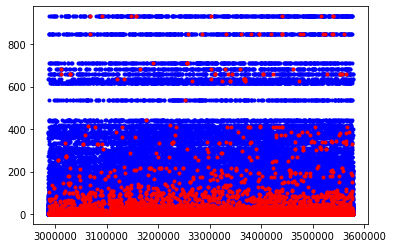

In [20]:
plt.plot(train[train.isFraud==0][train.ProductCD=='W']['uid_w_3_count'], '.b')
plt.plot(train[train.isFraud==1][train.ProductCD=='W']['uid_w_3_count'], '.r')

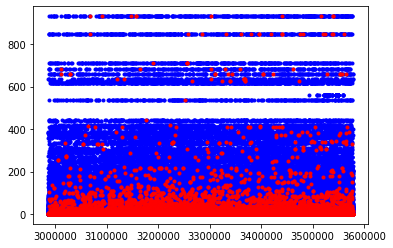

In [21]:
plt.plot(train[train.isFraud==0]['uid_w_3_count'], '.b')
plt.plot(train[train.isFraud==1]['uid_w_3_count'], '.r')

In [16]:
# train[use_features].to_pickle('../input/features/train_uid_features.pkl')
# test[use_features].to_pickle('../input/features/test_uid_features.pkl')